# Восстановление кривой из цены свопа

$$S_{2Y} = \frac{1 - D_{24M}}{0.5 (D_{6M} + D_{12M} + D_{18M} + D_{24M}) }$$

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize

In [2]:
global DF
def DF(L,m):
    return 1.0 / (1.0 + L*0.01*m/12)

global rate 
def rate(D,m):
    return (1/D - 1)*100*12/m

global tenors 
tenors = [3, 6, 9, 12, 15, 18, 21, 24]
L3 = 1.120
L6 = 1.430
L12 = 1.814
S2 = 1.684

In [3]:
def getLibors(L3, L6, L12, L24, method):
    if (method =='loglinear'):
        D18 = np.sqrt(DF(L24,24)*DF(L12,12))
        L18 = rate(D18,18)
        D9 = np.sqrt(DF(L12,12)*DF(L6,6))
        L9 = rate(D9,9)
        D15 = np.sqrt(DF(L12,12)*DF(L18,18))
        L15 = rate(D15,15)
        D21 = np.sqrt(DF(L18,18)*DF(L24,24))
        L21 = rate(D21,21)
        return [L3, L6, L9, L12, L15, L18, L21, L24.tolist()]
    elif method in ('cubic', 'linear', 'quadratic'):
        knownMonths = [3, 6, 12, 24]
        knownY = [L3, L6, L12, L24]
        f = scipy.interpolate.interp1d(knownMonths, knownY, method)
        return f(tenors) 
    
def get3M(libor, step=3):
    monthly = []
    for i in xrange(len(libors)-1):
        df1=DF(libor[i],(i+1)*step)
        df2=DF(libor[i+1],(i+2)*step)
        r = (df1 / df2 - 1)/step*12*100
        monthly.append(r)
    return monthly

## Использование линейной интерполяции

$$D_{18M}  = \frac{D_{24M} + D_{12M}}{2}$$

In [4]:
def FLin(S2,L6,L12):
    return (4 - 2*S2*0.01*DF(L6,6) - 3*S2*0.01*DF(L12,12)) / (4 + 2*S2*0.01)

D24 = FLin(S2,L6,L12)
L24 = rate(D24,24)
L18 = 0.5*(L24 + L12)
libors = getLibors(L3, L6, L12, L24, 'linear')
print libors
print get3M(libors)

[ 1.12        1.43        1.622       1.814       1.73305107  1.65210215
  1.57115322  1.4902043 ]
[1.7351416035102041, 1.9917589236955635, 2.3612750885478206, 1.3841469445361021, 1.2209088017764103, 1.0592107996382438, 0.89884783011440206]


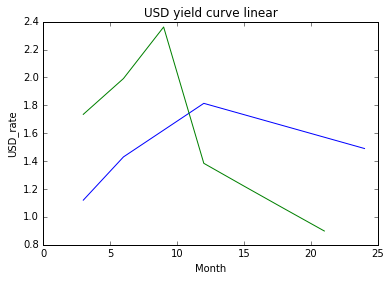

In [5]:
plt.title('USD yield curve linear')
plt.xlabel('Month')
plt.ylabel('USD_rate')
plt.plot(tenors, libors)
plt.plot(tenors[0:-1], get3M(libors))

## Лог-линейная интерполяция

$$D_{18M}  = \sqrt{D_{24M}D_{12M}}$$

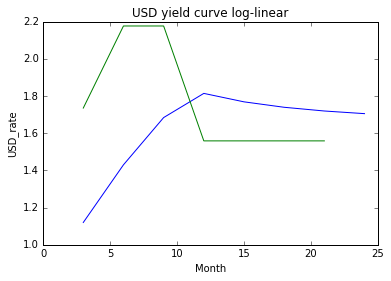

In [9]:
def F(x, S2, L6, L12):
    S2 = 0.01*S2
    D6 = DF(L6,6)
    D12 = DF(L12,12)
    D24 = DF(x,24)
    D18 = np.sqrt(D12*D24)
    return 0.5*S2*(D6 + D12 + D18 + D24) - 1 + D24

L24 = scipy.optimize.broyden1(lambda x: F(x,S2,L6,L12), 1.0, f_tol=1e-6)
D18 = np.sqrt(DF(L12,12)*DF(L24,24))
L18 = rate(D18, 18)

libors=getLibors(L3, L6, L12, L24, 'loglinear')

plt.title('USD yield curve log-linear')
plt.xlabel('Month')
plt.ylabel('USD_rate')
plt.plot(tenors, libors)
plt.plot(tenors[0:-1], get3M(libors))


## Кубические сплайны

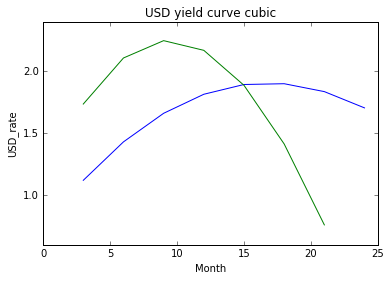

In [11]:
def F(x, S2, L3, L6, L12):
    S2 = 0.01*S2
    D6 = DF(L6,6)
    D12 = DF(L12,12)
    f = scipy.interpolate.interp1d([3,6,12,24], [L3,L6,L12,x], 'cubic')
    L18 = f(18)
    D18 = DF(L18, 18)
    D24 = DF(x, 24)
    return 0.5*S2*(D6 + D12 + D18 + D24) - 1 + D24

L24 = scipy.optimize.broyden1(lambda x: F(x,S2,L3,L6,L12), 1.0, f_tol=1e-6)
libors=getLibors(L3, L6, L12, L24, 'cubic')
plt.title('USD yield curve cubic')
plt.xlabel('Month')
plt.ylabel('USD_rate')
plt.plot(tenors, libors)
plt.plot(tenors[0:-1], get3M(libors))

## Квадратичная интерполяция

[ 1.12        1.43        1.66078235  1.814       1.89295889  1.90096496
  1.83801819  1.7041186 ]


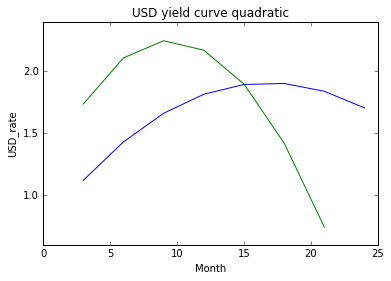

In [13]:
def F(x, S2, L3, L6, L12):
    S2 = 0.01*S2
    D6 = DF(L6,6)
    D12 = DF(L12,12)
    f = scipy.interpolate.interp1d([3,6,12,24], [L3,L6,L12,x], 'quadratic')
    L18 = f(18)
    D18 = DF(L18, 18)
    D24 = DF(x, 24)
    return 0.5*S2*(D6 + D12 + D18 + D24) - 1 + D24

L24 = scipy.optimize.broyden1(lambda x: F(x,S2,L3,L6,L12), 1.0, f_tol=1e-6)

f = scipy.interpolate.interp1d([3,6,12,24], [L3,L6,L12,L24], 'quadratic')
L18 = f(18)
libors = getLibors(L3, L6, L12, L24, 'quadratic')
print libors
plt.title('USD yield curve quadratic')
plt.xlabel('Month')
plt.ylabel('USD_rate')
plt.plot(tenors, libors)
plt.plot(tenors[0:-1], get3M(libors))